In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from llama import Workflow, Llama

os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29502"

workflow = Workflow.build(
    ckpt_dir='/scratch4/jeisner1/tjbai/llama_8b',
    tokenizer_path='/scratch4/jeisner1/tjbai/llama_8b/tokenizer.model',
    max_seq_len=8192,
    max_batch_size=8,
    model_parallel_size=1,
    max_nodes=100,
    use_lora=True,
    lora_rank=32,
    lora_alpha=64,
    lora_dropout=0.05
)

llama = Llama(workflow.model, workflow.tokenizer)

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
Converting to LoRA
Loaded in 18.34 seconds


## sanity checks

In [ ]:
import numpy as np
from llama.workflows.prisoners import prisoners_baseline, baseline_nll

baseline_outputs = prisoners_baseline(
    llama=llama,
    payoff=(5, 3, 1, 0),
    alice_first=True,
    alice_strategy=None,
    temperature=1.0,
    top_p=1.0,
)

print(-np.mean(baseline_outputs['bob_log_probs'][0]))

nll = baseline_nll(
    llama, baseline_outputs,
    payoff=(5, 3, 1, 0),
    alice_first=True,
    alice_strategy=None,
)

print(np.mean(nll['bob_nll'][0]))

1.0237316084772932
1.0225695927887126


In [12]:
import numpy as np
from llama.workflows.prisoners import prisoners_cached, cached_nll

workflow.reset()
cached_outputs = prisoners_cached(
    workflow=workflow,
    payoff=(5, 3, 1, 0),
    alice_first=False,
    alice_strategy=None,
)

print(-(sum(cached_outputs['bob_log_probs'][0]) / len(cached_outputs['bob_log_probs'][0])).cpu().item())

nll = cached_nll(
    workflow, cached_outputs,
    payoff=(5, 3, 1, 0),
    alice_first=False,
    alice_strategy=None,
)

print(np.mean(nll['bob_nll'][0]))

0.8704151511192322
0.8746917659729169


In [8]:
cached_outputs.keys()

dict_keys(['alice_message_ids', 'bob_message_ids', 'bob_log_probs', 'plan_ids', 'decision_ids', 'alice_context', 'bob_context'])

In [16]:
jwn = {}
for k, v in cached_outputs.items():
    if k == 'bob_log_probs': continue
    jwn[k] = v

In [17]:
import json

with open('tmp', 'w') as f:
    f.write(json.dumps(jwn))

## load before data

In [3]:
import json

with open('/home/tbai4/llama3/dumps/prisoners/prisoners_baseline.jsonl') as f:
    data = [json.loads(line) for line in f]
    
baseline_no_strategy = [d['outputs'] for d in data[:100]]
baseline_always_cooperate = [d['outputs'] for d in data[101:200]]
baseline_always_defect = [d['outputs'] for d in data[200:]]

with open('/home/tbai4/llama3/dumps/prisoners/prisoners_cached_paired.jsonl') as f:
    data = [json.loads(line) for line in f]
    
cached_no_strategy = [d['outputs'] for d in data[:100]]
cached_always_cooperate = [d['outputs'] for d in data[101:200] if d['strategy'] == 'always_cooperate']
cached_always_defect = [d['outputs'] for d in data[200:300] if d['strategy'] == 'always_defect']

## utils

In [4]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from llama.workflows.prisoners import baseline_nll, cached_nll

def load_ckpt(ckpt_path):
    ckpt = torch.load(ckpt_path, weights_only=True)
    for weight, param in zip(ckpt['trainable_params'], workflow.model.get_trainable_parameters()):
        param.data.copy_(weight)

def plot(outputs, differences):
    baseline_res = []
    llama.model.set_adapter_state(enabled=False)
    for i, b in tqdm(enumerate(outputs)):
        try:
            baseline_res.append(baseline_nll(
                llama, b,
                payoff=(5,3,1,0),
                alice_first=(i < 50),
                alice_strategy=None
            ))
        except:
            baseline_res.append({'bob_nll': [[1e9], [1e9]], 'alice_nll': [[1e9], [1e9]]})

    cached_res = []
    workflow.model.set_adapter_state(enabled=True)
    for i, b in tqdm(enumerate(outputs)):
        try:
            cached_res.append(cached_nll(
                workflow, b,
                payoff=(5,3,1,0),
                alice_first=(i < 50),
                alice_strategy=None,
            ))
        except:
            cached_res.append({'bob_nll': [[1e9], [1e9]], 'alice_nll': [[1e9], [1e9]]})

    sns.set_theme()

    baseline_first_means = [np.mean(b['bob_nll'][0]) for b in baseline_res]
    cached_first_means = [np.mean(b['bob_nll'][0]) for b in cached_res]

    baseline_second_means = [np.mean(b['bob_nll'][1]) for b in baseline_res]
    cached_second_means = [np.mean(b['bob_nll'][1]) for b in cached_res]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.scatter(
        [baseline_first_means[i] for i in range(len(baseline_first_means)) if not differences[i]],
        [cached_first_means[i] for i in range(len(cached_first_means)) if not differences[i]],
        s=100, alpha=0.7, color='blue', label='Same decision'
    )
    ax1.scatter(
        [baseline_first_means[i] for i in range(len(baseline_first_means)) if differences[i]],
        [cached_first_means[i] for i in range(len(cached_first_means)) if differences[i]],
        s=100, alpha=0.7, color='red', label='Different decision'
    )
    ax1.set_xlim(0, 1.5)
    ax1.set_ylim(0, 1.5)
    ax1.plot([0, 1.5], [0, 1.5], 'k--', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    ax1.set_title('First Message')
    ax1.set_xlabel('Baseline NLL')
    ax1.set_ylabel('Choreographed NLL')
    ax1.legend()

    ax2.scatter(
        [baseline_second_means[i] for i in range(len(baseline_second_means)) if not differences[i]],
        [cached_second_means[i] for i in range(len(cached_second_means)) if not differences[i]],
        s=100, alpha=0.7, color='blue', label='Same decision'
    )
    ax2.scatter(
        [baseline_second_means[i] for i in range(len(baseline_second_means)) if differences[i]],
        [cached_second_means[i] for i in range(len(cached_second_means)) if differences[i]],
        s=100, alpha=0.7, color='red', label='Different decision'
    )
    ax2.set_xlim(0, 1.5)
    ax2.set_ylim(0, 1.5)
    ax2.plot([0, 1.5], [0, 1.5], 'k--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Second Message')
    ax2.set_xlabel('Baseline NLL')
    ax2.set_ylabel('Choreographed NLL')
    ax2.legend()

    for ax in [ax1, ax2]:
        sns.despine(ax=ax)

    plt.tight_layout()
    return {
        'fig': fig,
        'baseline_first_means': baseline_first_means,
        'cached_first_means': cached_first_means,
        'baseline_second_means': baseline_second_means,
        'cached_second_means': cached_second_means,
    }

## baseline, before training

100it [02:19,  1.39s/it]
100it [00:59,  1.69it/s]
100it [02:14,  1.35s/it]
100it [00:57,  1.73it/s]


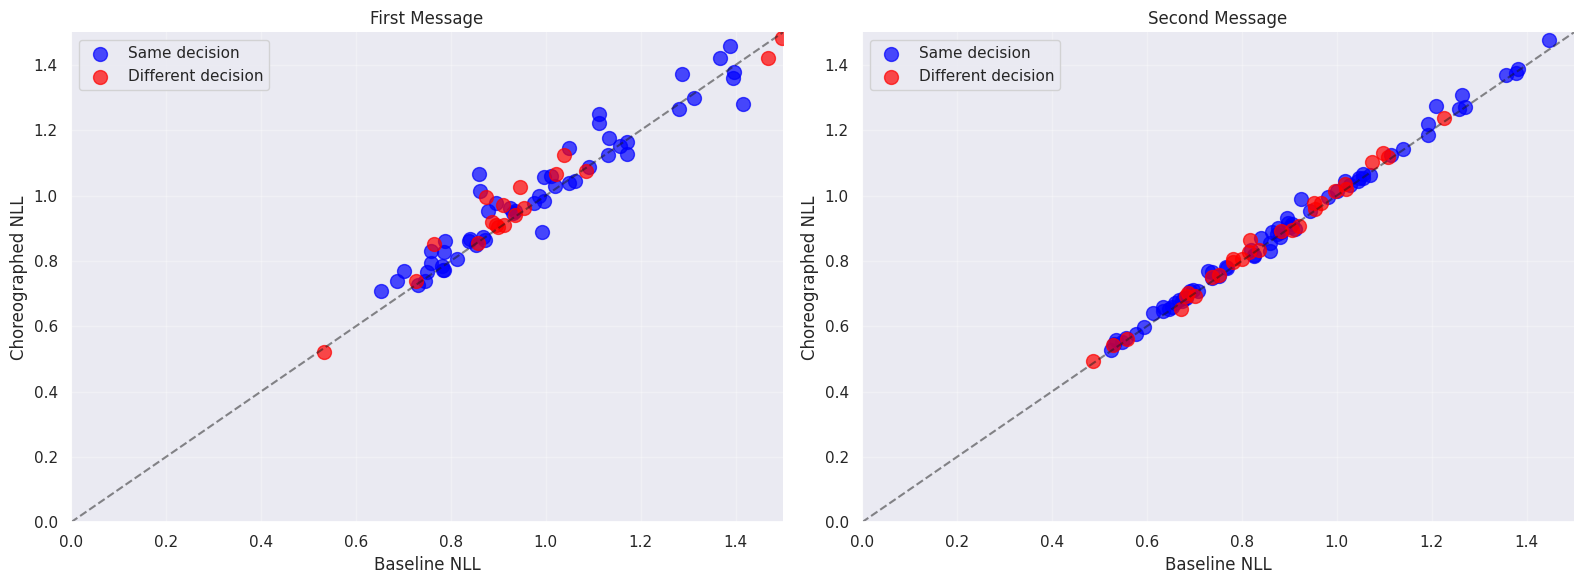

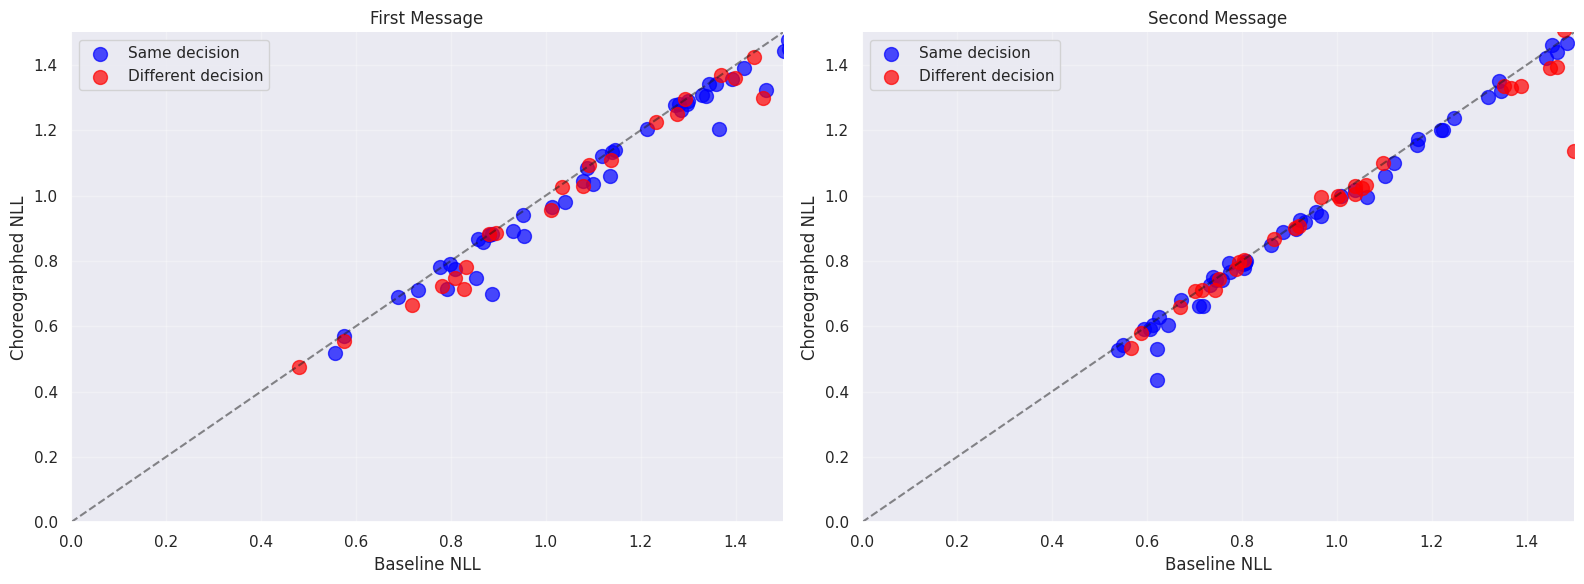

In [21]:
cached_bob_decisions = [workflow.tokenizer.decode(c['decision_ids'][1]) for c in cached_no_strategy]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_no_strategy]
differences = [("cooperate" in cached_choice.lower()) != ("cooperate" in baseline_choice.lower()) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]

fig_baseline = plot(baseline_no_strategy, differences)
fig_cached = plot(cached_no_strategy, differences)

fig_baseline.savefig('baseline_no_strategy.png')
fig_cached.savefig('cached_no_strategy.png')

## baseline, after training

Cached cooperate: 70
Baseline cooperate: 70
McNemar's p-value before: 0.06524533522315325


99it [02:09,  1.31s/it]
99it [01:27,  1.13it/s]


Cached cooperate: 72
Baseline cooperate: 72


ValueError: operands could not be broadcast together with shapes (100,) (99,) 

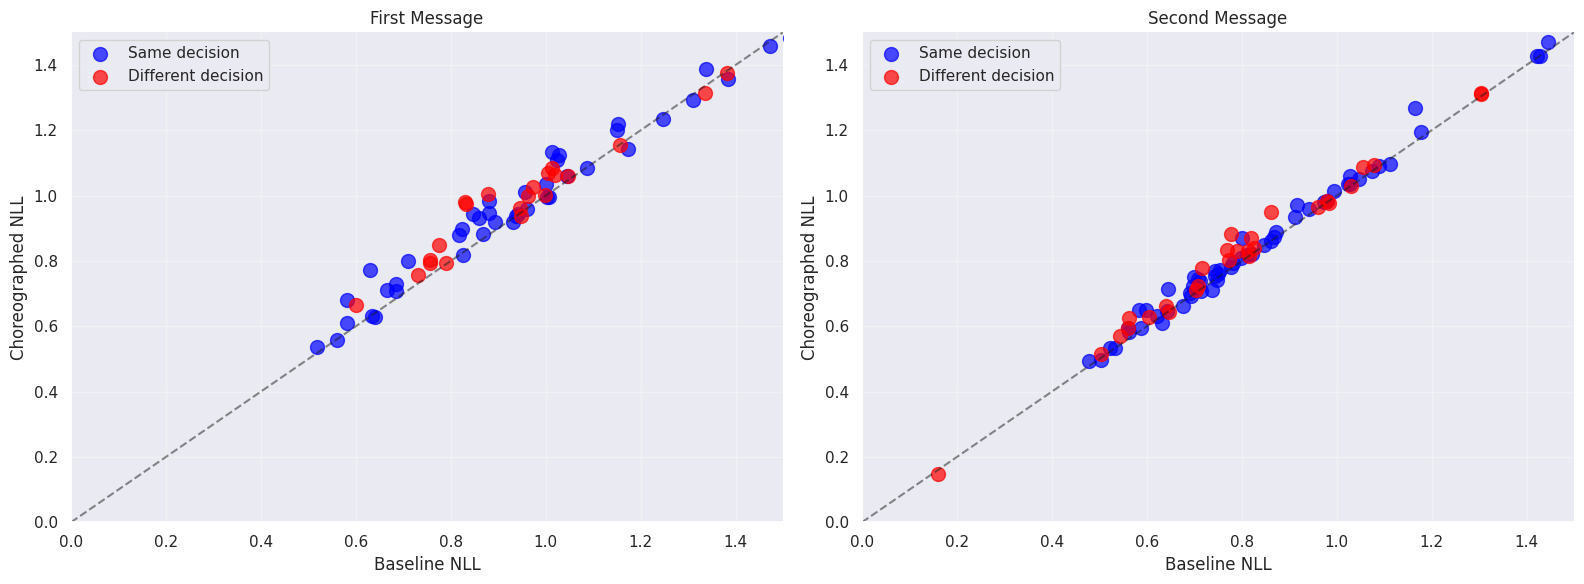

In [5]:
from llama.util import run_mcnemars_test

# before
workflow.model.set_adapter_state(enabled=False)
cached_bob_decisions = [workflow.tokenizer.decode(c['decision_ids'][1]) for c in cached_no_strategy]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_no_strategy]

cached_cooperate = ["COOPERATE" in choice for choice in cached_bob_decisions]
baseline_cooperate = ["COOPERATE" in choice for choice in baseline_bob_decisions]
print(f'Cached cooperate: {sum(cached_cooperate)}')
print(f'Baseline cooperate: {sum(cached_cooperate)}')
print('McNemar\'s p-value before:', run_mcnemars_test(cached_cooperate, baseline_cooperate)['result'])

differences = [("COOPERATE" in cached_choice) != ("COOPERATE" in baseline_choice) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]
pre_reverse_kl = plot(baseline_no_strategy, differences)

# after
load_ckpt('/scratch4/jeisner1/tjbai/checkpoints/prisoners/baseline/lora_epoch-0_step-195.pt')
workflow.model.set_adapter_state(enabled=True)
with open('/home/tbai4/llama3/dumps/prisoners/prisoners_ft_eval_always_cooperate.jsonl') as f:
    data = [json.loads(line) for line in f][200:300]
    
cached_bob_decisions = [d['bob_final'] for d in data]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_always_cooperate]

cached_cooperate = ["COOPERATE" in choice for choice in cached_bob_decisions]
baseline_cooperate = ["COOPERATE" in choice for choice in baseline_bob_decisions]
print(f'Cached cooperate: {sum(cached_cooperate)}')
print(f'Baseline cooperate: {sum(cached_cooperate)}')
print('McNemar\'s p-value after:', run_mcnemars_test(cached_cooperate, baseline_cooperate)['result'])

differences = [("COOPERATE" in cached_choice) != ("COOPERATE" in baseline_choice) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]
post_reverse_kl = plot(baseline_always_cooperate, differences)
post_reverse_kl['fig'].savefig('baseline_always_cooperate_ft.png')

# compare
pre_diffs = np.array(pre_reverse_kl['cached_first_means']) - np.array(pre_reverse_kl['baseline_first_means'])
post_diffs = np.array(post_reverse_kl['cached_first_means']) - np.array(post_reverse_kl['baseline_first_means'])
valid_mask = np.array(pre_reverse_kl['baseline_first_means']) <= np.percentile(pre_reverse_kl['baseline_first_means'], 75)
pre_diffs = pre_diffs[valid_mask]
post_diffs = post_diffs[valid_mask]

print(f"Mean pre-training KL residual: {np.mean(pre_diffs):.4f}")
print(f"Mean post-training KL residual: {np.mean(post_diffs):.4f}")

plt.figure(figsize=(7, 7))
plt.scatter(pre_diffs, post_diffs, alpha=0.7, s=40, color='navy', edgecolor='white', linewidth=0.5)

x_line = np.linspace(-0.25, 0.25, 1000)
plt.plot(x_line, x_line, 'r--', alpha=0.7, label='y=x')

plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)

plt.xlabel('Pre-Training KL Residual', fontsize=12)
plt.ylabel('Post-Training KL Residual', fontsize=12)
plt.title('KL Divergence Residual Before vs. After Training', fontsize=14)

plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('kl_residuals_baseline.png')

In [6]:
with open('/home/tbai4/llama3/dumps/prisoners/prisoners_ft_eval_baseline.jsonl') as f:
    data = [json.loads(line) for line in f][200:300]
    
cached_bob_decisions = [d['bob_final'] for d in data]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_no_strategy]

cached_cooperate = ["COOPERATE" in choice for choice in cached_bob_decisions]
baseline_cooperate = ["COOPERATE" in choice for choice in baseline_bob_decisions]
print(f'Cached cooperate: {sum(cached_cooperate)}')
print(f'Baseline cooperate: {sum(cached_cooperate)}')
print('McNemar\'s p-value after:', run_mcnemars_test(cached_cooperate, baseline_cooperate)['result'])

Cached cooperate: 80
Baseline cooperate: 80
McNemar's p-value after: 0.711071103811264


## always cooperate, before training

99it [02:09,  1.31s/it]
99it [01:28,  1.11it/s]
99it [02:07,  1.29s/it]
99it [01:28,  1.12it/s]


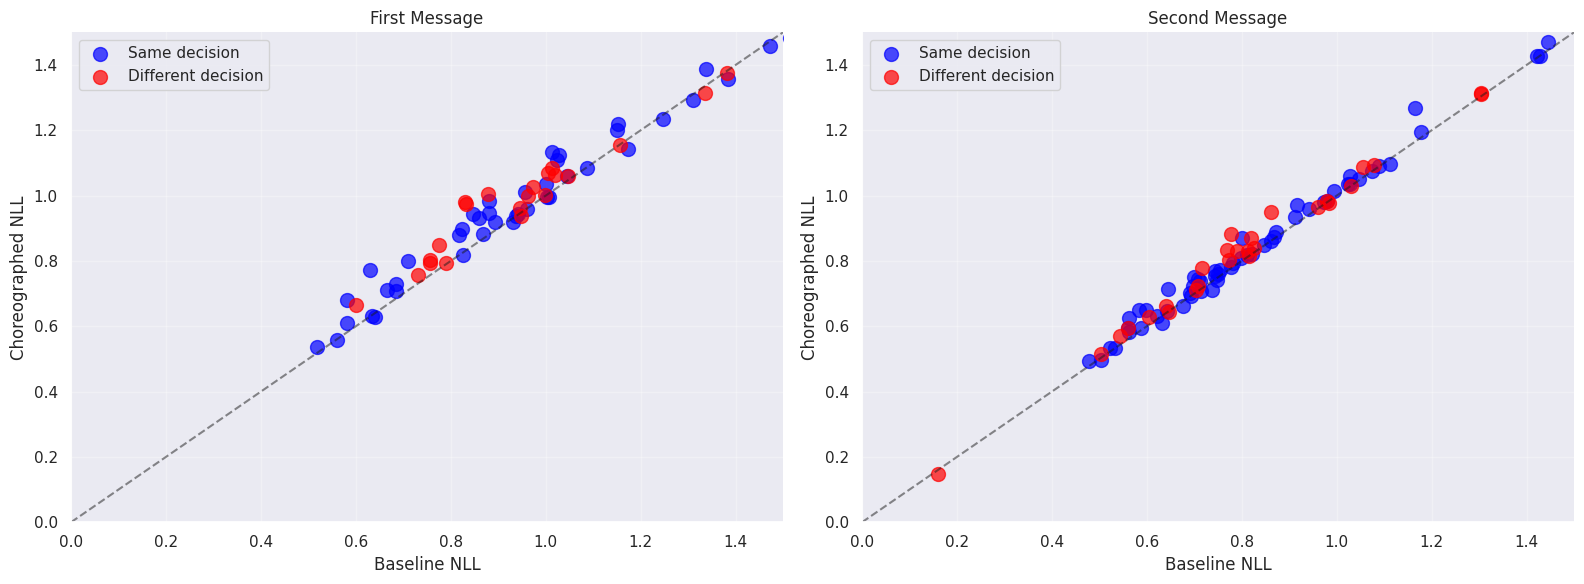

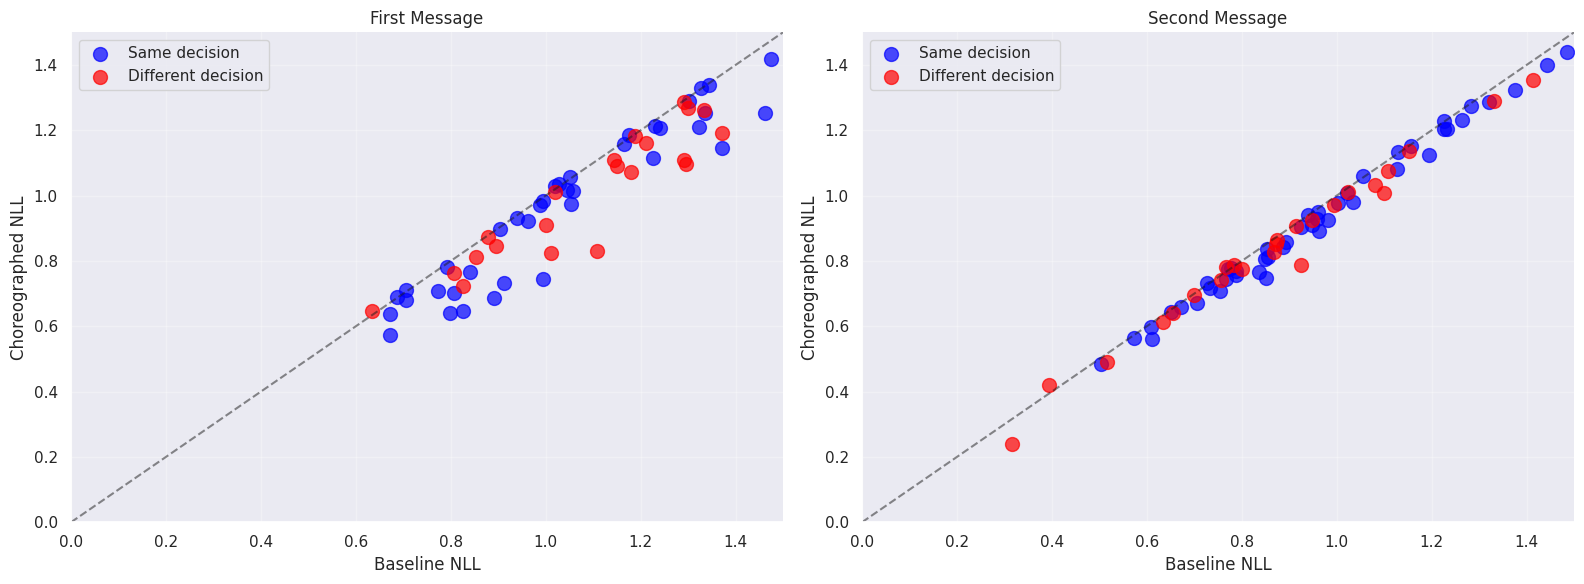

In [5]:
workflow.model.set_adapter_state(enabled=False)

cached_bob_decisions = [workflow.tokenizer.decode(c['decision_ids'][1]) for c in cached_always_cooperate]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_always_cooperate]
differences = [("cooperate" in cached_choice.lower()) != ("cooperate" in baseline_choice.lower()) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]

pre_reverse_kl = plot(baseline_always_cooperate, differences)
pre_forward_kl = plot(cached_always_cooperate, differences)

## always cooperate, after training

McNemar's p-value before: 0.12144948495551944


99it [02:09,  1.31s/it]
99it [01:28,  1.12it/s]


McNemar's p-value after: 0.45825831964612007


99it [02:09,  1.31s/it]
99it [01:28,  1.12it/s]


Mean pre-training KL residual: 0.0293
Mean post-training KL residual: 0.0063


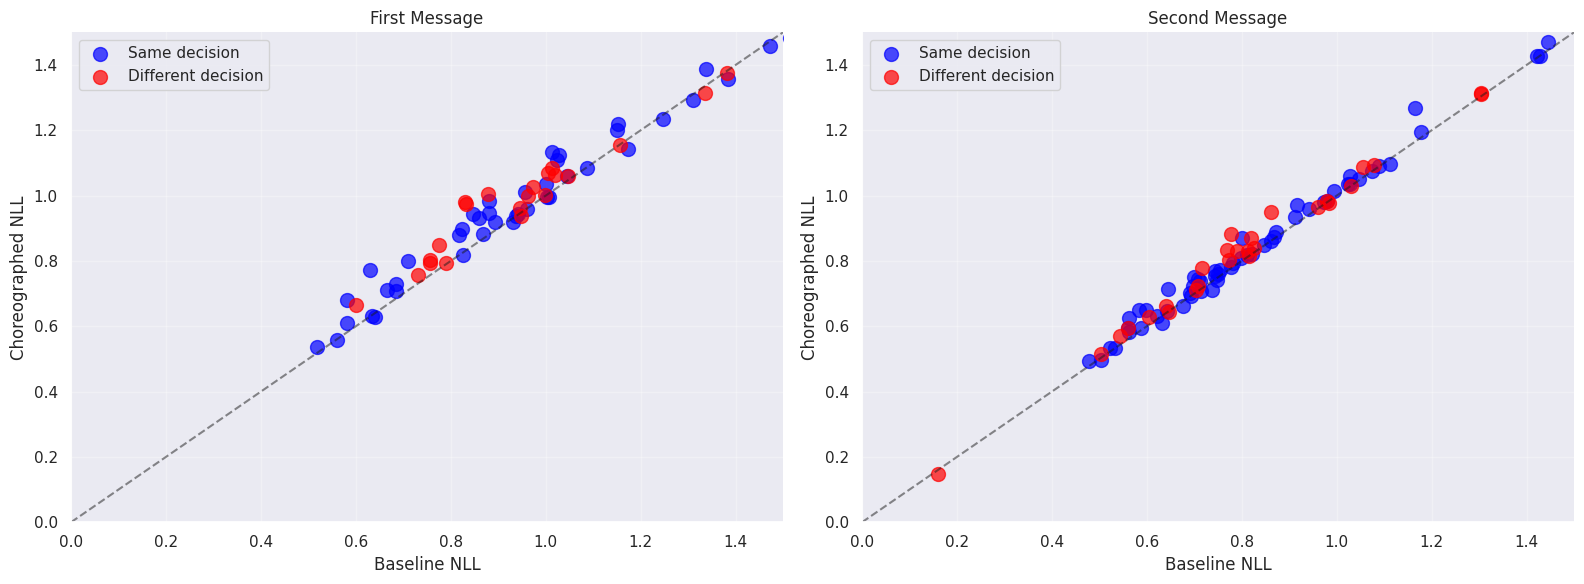

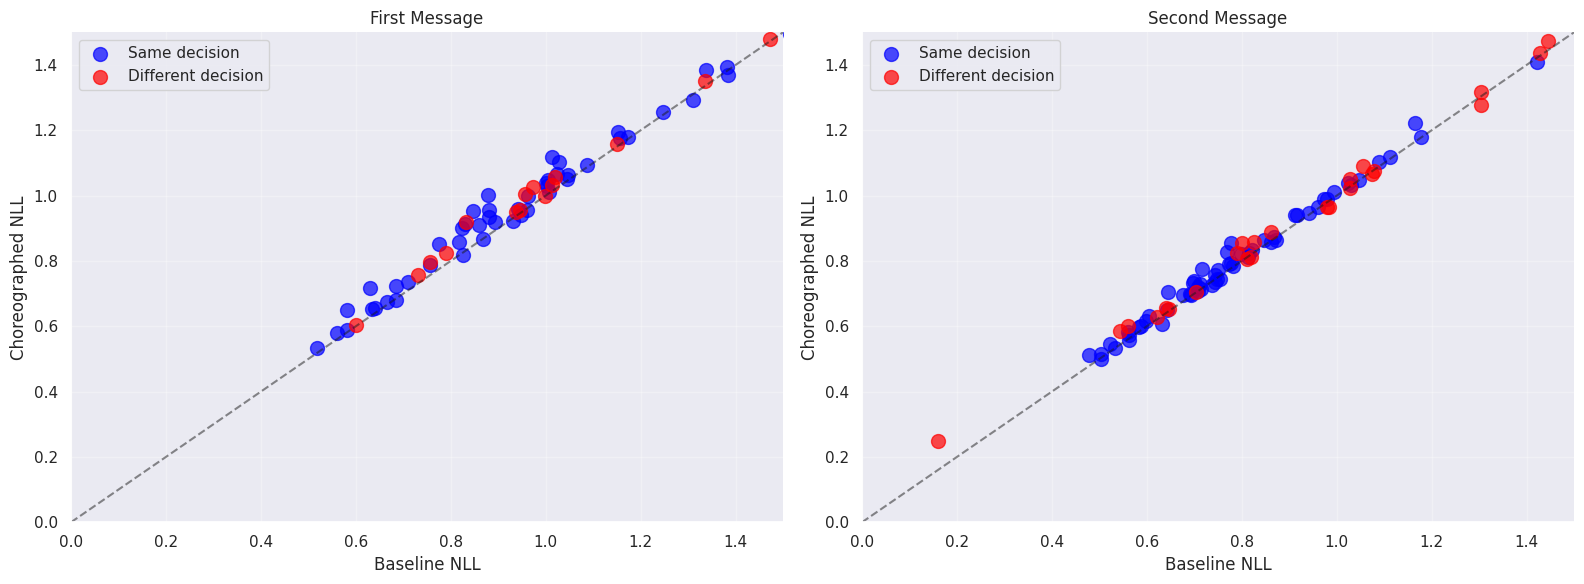

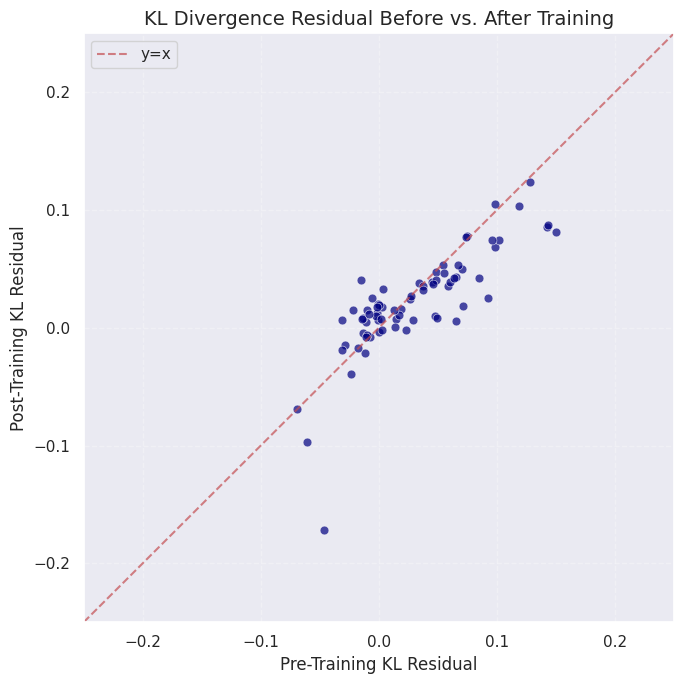

In [7]:
from llama.util import run_mcnemars_test

# before
workflow.model.set_adapter_state(enabled=False)
cached_bob_decisions = [workflow.tokenizer.decode(c['decision_ids'][1]) for c in cached_always_cooperate]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_always_cooperate]

cached_cooperate = ["cooperate" in choice.lower() for choice in cached_bob_decisions]
baseline_cooperate = ["cooperate" in choice.lower() for choice in baseline_bob_decisions]
print('McNemar\'s p-value before:', run_mcnemars_test(cached_cooperate, baseline_cooperate)['result'])

differences = [("cooperate" in cached_choice.lower()) != ("cooperate" in baseline_choice.lower()) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]
pre_reverse_kl = plot(baseline_always_cooperate, differences)

# after
load_ckpt('/scratch4/jeisner1/tjbai/checkpoints/prisoners/always_cooperate/lora_epoch-0_step-195.pt')
workflow.model.set_adapter_state(enabled=True)
with open('/home/tbai4/llama3/dumps/prisoners/prisoners_ft_eval_always_cooperate.jsonl') as f:
    data = [json.loads(line) for line in f][101:200]
    
cached_bob_decisions = [d['bob_final'] for d in data]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_always_cooperate]

cached_cooperate = ["cooperate" in choice.lower() for choice in cached_bob_decisions]
baseline_cooperate = ["cooperate" in choice.lower() for choice in baseline_bob_decisions]
print('McNemar\'s p-value after:', run_mcnemars_test(cached_cooperate, baseline_cooperate)['result'])

differences = [("cooperate" in cached_choice.lower()) != ("cooperate" in baseline_choice.lower()) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]
post_reverse_kl = plot(baseline_always_cooperate, differences)
post_reverse_kl['fig'].savefig('baseline_always_cooperate_ft.png')

# compare
pre_diffs = np.array(pre_reverse_kl['cached_first_means']) - np.array(pre_reverse_kl['baseline_first_means'])
post_diffs = np.array(post_reverse_kl['cached_first_means']) - np.array(post_reverse_kl['baseline_first_means'])
valid_mask = np.array(pre_reverse_kl['baseline_first_means']) <= np.percentile(pre_reverse_kl['baseline_first_means'], 75)
pre_diffs = pre_diffs[valid_mask]
post_diffs = post_diffs[valid_mask]

print(f"Mean pre-training KL residual: {np.mean(pre_diffs):.4f}")
print(f"Mean post-training KL residual: {np.mean(post_diffs):.4f}")

plt.figure(figsize=(7, 7))
plt.scatter(pre_diffs, post_diffs, alpha=0.7, s=40, color='navy', edgecolor='white', linewidth=0.5)

x_line = np.linspace(-0.25, 0.25, 1000)
plt.plot(x_line, x_line, 'r--', alpha=0.7, label='y=x')

plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)

plt.xlabel('Pre-Training KL Residual', fontsize=12)
plt.ylabel('Post-Training KL Residual', fontsize=12)
plt.title('KL Divergence Residual Before vs. After Training', fontsize=14)

plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('kl_residuals_always_cooperate.png')

## always defect, before training

100it [02:10,  1.31s/it]
100it [00:56,  1.78it/s]
100it [02:10,  1.31s/it]
100it [00:56,  1.78it/s]


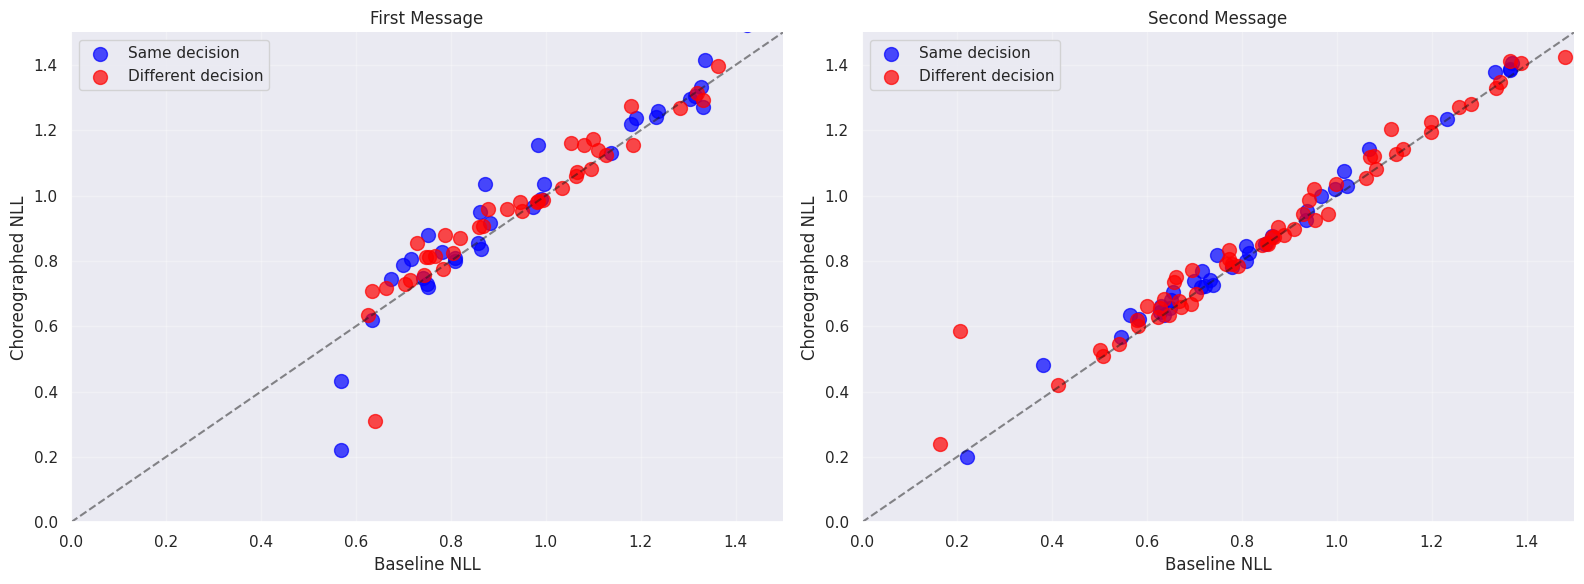

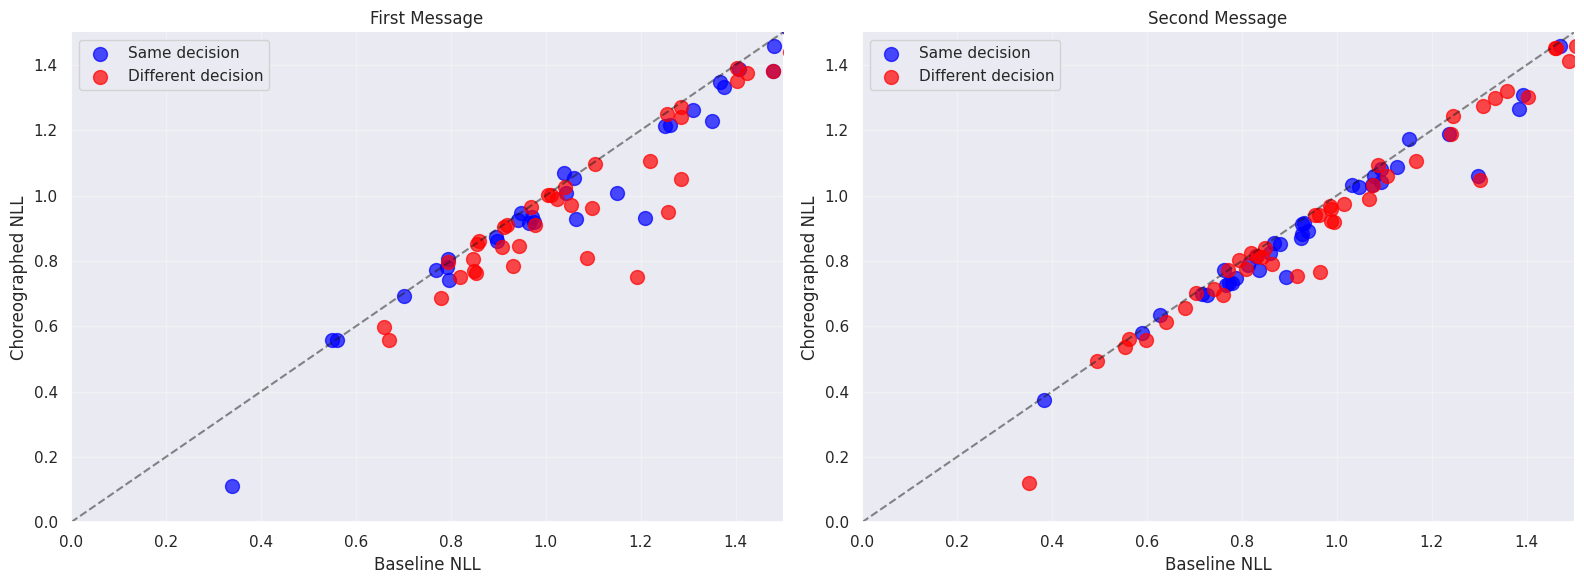

In [34]:
cached_bob_decisions = [workflow.tokenizer.decode(c['decision_ids'][1]) for c in cached_always_defect]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_always_defect]
differences = [("cooperate" in cached_choice.lower()) != ("cooperate" in baseline_choice.lower()) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]

fig_baseline = plot(baseline_always_defect, differences)
fig_cached = plot(cached_always_defect, differences)

fig_baseline.savefig('baseline_always_defect.png')
fig_cached.savefig('cached_always_defect.png')

## always defect, after training

McNemar's p-value before: 4.7104376093953786e-05


100it [02:09,  1.29s/it]
100it [01:28,  1.13it/s]


McNemar's p-value after: 0.617719317029696


100it [02:09,  1.29s/it]
100it [01:27,  1.14it/s]


Mean pre-training KL residual: 0.0191
Mean post-training KL residual: -0.0286


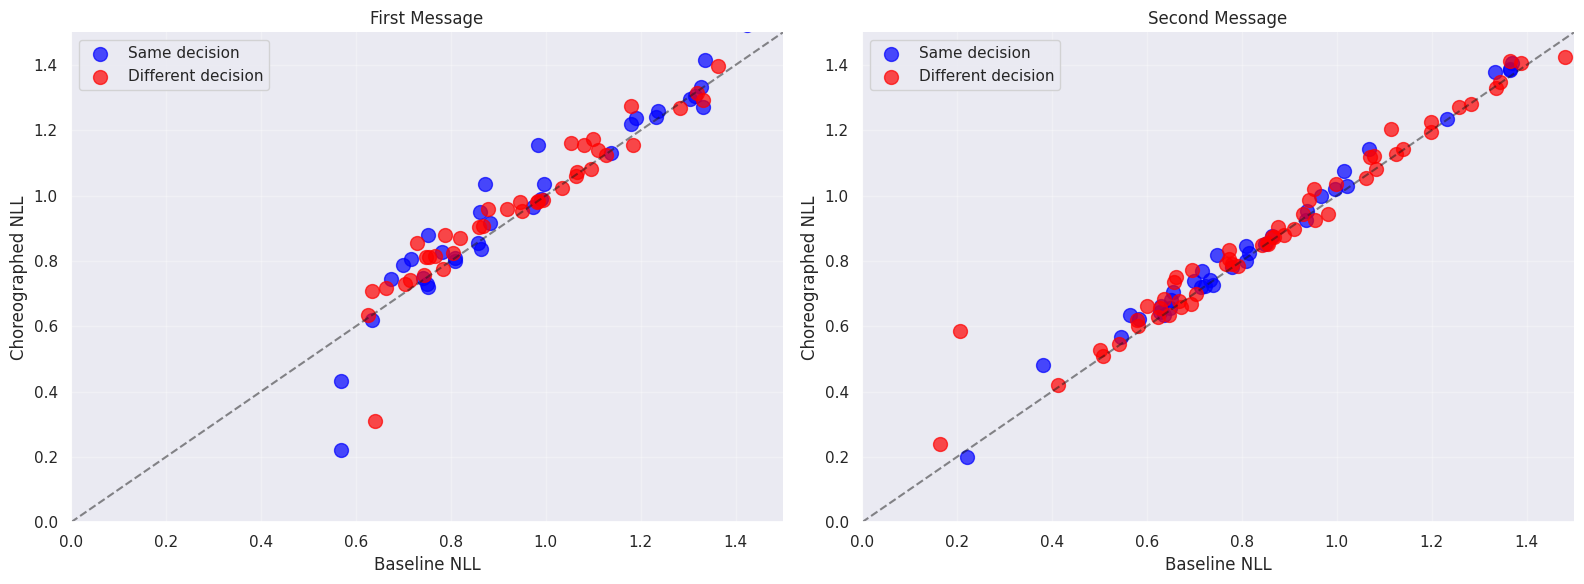

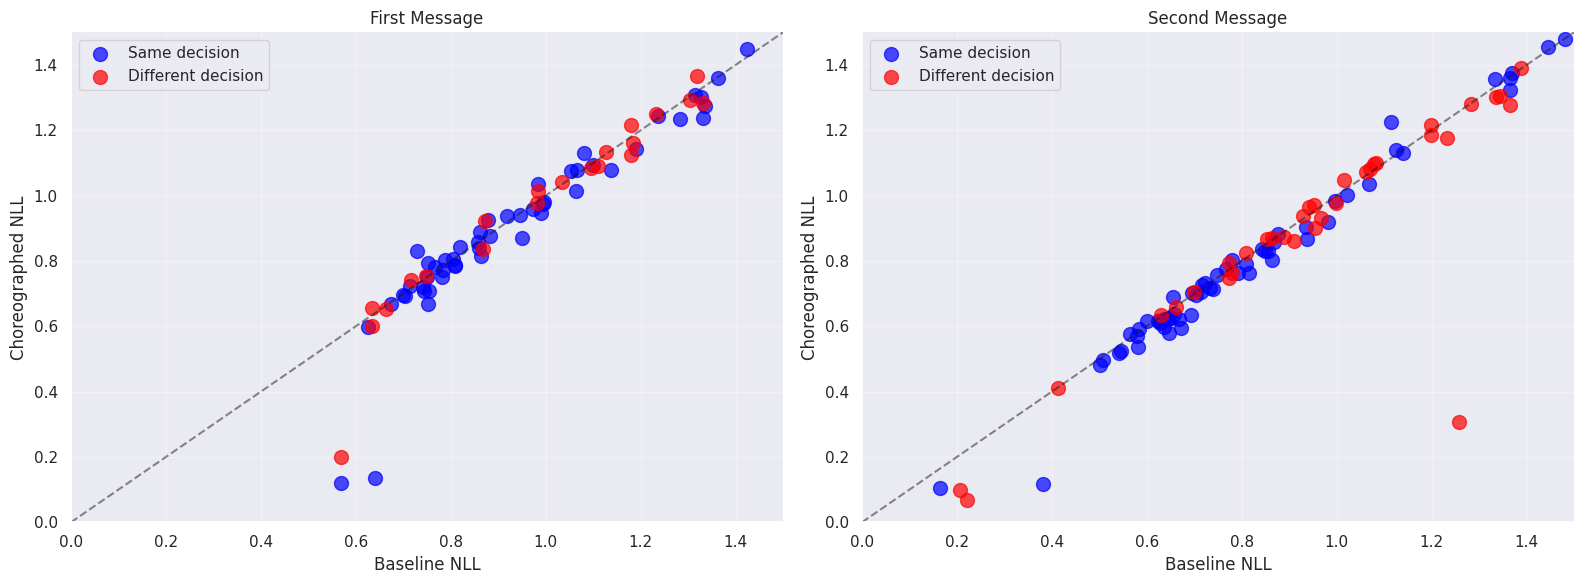

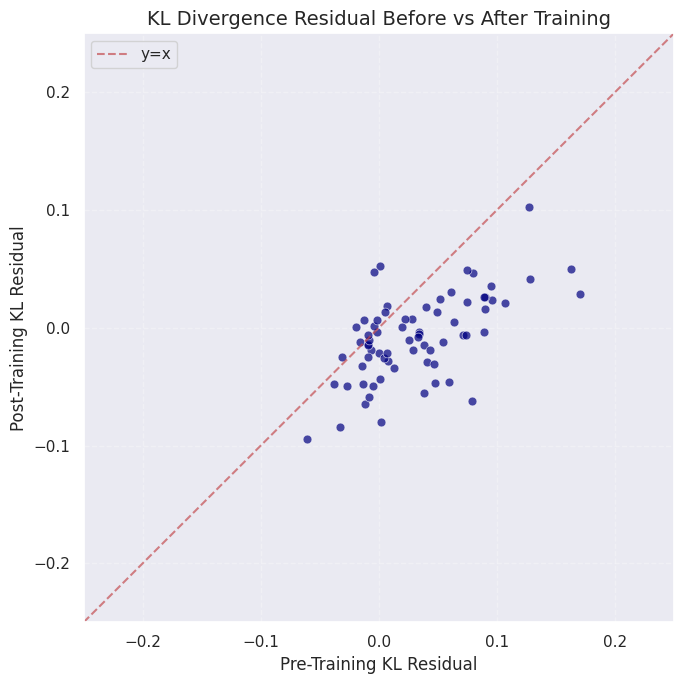

In [6]:
from llama.util import run_mcnemars_test

# before
workflow.model.set_adapter_state(enabled=False)
cached_bob_decisions = [workflow.tokenizer.decode(c['decision_ids'][1]) for c in cached_always_defect]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_always_defect]

cached_cooperate = ["cooperate" in choice.lower() for choice in cached_bob_decisions]
baseline_cooperate = ["cooperate" in choice.lower() for choice in baseline_bob_decisions]
print('McNemar\'s p-value before:', run_mcnemars_test(cached_cooperate, baseline_cooperate)['result'])

differences = [("cooperate" in cached_choice.lower()) != ("cooperate" in baseline_choice.lower()) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]
pre_reverse_kl = plot(baseline_always_defect, differences)

# after
load_ckpt('/scratch4/jeisner1/tjbai/checkpoints/prisoners/always_defect/lora_epoch-1_step-151.pt')
workflow.model.set_adapter_state(enabled=True)
with open('/home/tbai4/llama3/dumps/prisoners/prisoners_ft_eval_always_defect.jsonl') as f:
    data = [json.loads(line) for line in f][300:]
    
cached_bob_decisions = [d['bob_final'] for d in data]
baseline_bob_decisions = [workflow.tokenizer.decode(b['decision_ids'][1]) for b in baseline_always_defect]

cached_cooperate = ["cooperate" in choice.lower() for choice in cached_bob_decisions]
baseline_cooperate = ["cooperate" in choice.lower() for choice in baseline_bob_decisions]
print('McNemar\'s p-value after:', run_mcnemars_test(cached_cooperate, baseline_cooperate)['result'])

differences = [("cooperate" in cached_choice.lower()) != ("cooperate" in baseline_choice.lower()) for cached_choice, baseline_choice in zip(cached_bob_decisions, baseline_bob_decisions)]
post_reverse_kl = plot(baseline_always_defect, differences)
post_reverse_kl['fig'].savefig('baseline_always_defect_ft.png')

# compare
pre_diffs = np.array(pre_reverse_kl['cached_first_means']) - np.array(pre_reverse_kl['baseline_first_means'])
post_diffs = np.array(post_reverse_kl['cached_first_means']) - np.array(post_reverse_kl['baseline_first_means'])
valid_mask = np.array(pre_reverse_kl['baseline_first_means']) <= np.percentile(pre_reverse_kl['baseline_first_means'], 75)
pre_diffs = pre_diffs[valid_mask]
post_diffs = post_diffs[valid_mask]

print(f"Mean pre-training KL residual: {np.mean(pre_diffs):.4f}")
print(f"Mean post-training KL residual: {np.mean(post_diffs):.4f}")

plt.figure(figsize=(7, 7))
plt.scatter(pre_diffs, post_diffs, alpha=0.7, s=40, color='navy', edgecolor='white', linewidth=0.5)

x_line = np.linspace(-0.25, 0.25, 1000)
plt.plot(x_line, x_line, 'r--', alpha=0.7, label='y=x')

plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)

plt.xlabel('Pre-Training KL Residual', fontsize=12)
plt.ylabel('Post-Training KL Residual', fontsize=12)
plt.title('KL Divergence Residual Before vs After Training', fontsize=14)

plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('kl_residuals_always_defect.png')